# Fundamentals of Computer Vision [MO56316]

### Second assignment - Bag of Words

This work was made by Eduard Hogea (NIA: 1655116), Sisard Fatess Calvis (NIA: 1636087)


Contact - eduard.hogea00@e-uvt.ro and 1636087@uab.cat


On this notebook, we adress the objective of generating an image classification pipeline employing a Bag Of Visual Words (BOVW) algorithm.

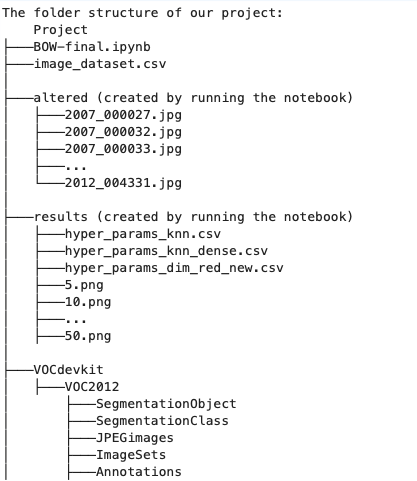

<font color='red'>Note: </font> All the results are saved in .csv files, so there is no need to run some of the cells.

In [1]:
import os
import cv2
import numpy as np
import pickle
import json
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from tqdm import tqdm
from joblib import Parallel, delayed, cpu_count
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from typing import List, Dict, Tuple, Any
from copy import deepcopy
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model._base import BaseEstimator
from copy import deepcopy
from sklearn.preprocessing import LabelBinarizer
import pandas as pd
from pylab import rcParams
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)
from sklearn import svm
import seaborn as sns
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import *
from scipy import interp
from itertools import cycle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import lxml
import warnings
import pathlib
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

<IPython.core.display.Javascript object>

In [2]:
def load_image(path: str) -> Tuple[np.ndarray, np.ndarray]:
    """
    Load image at path.
    """
    return cv2.imread(path)


def load_images(files: List[str], desc: str, n_process: int = cpu_count()) -> Tuple[np.ndarray]:
    """
    Load a list of images by their full filenames.
    """
    images = Parallel(n_jobs=n_process, prefer="threads")(
        delayed(load_image)(file) for file in tqdm(files, desc=desc))
    print(f"read: {len(images)} images")
    return images

### Visualization functions

In [3]:
def plot_params(df: np.ndarray, detector: str, xvar: str, yvar: str, zvar: str, linestyle='-', figsize=(5, 3)):
    fig = plt.figure(figsize=figsize)
    lvls = df[zvar].unique()
    data = df.copy()[df['detector'] == detector]
    for i in lvls:
        plt.errorbar(x=data[data[zvar]==i][xvar],
                     y=data[data[zvar]==i][yvar], 
                     yerr=data[data[zvar]==i][f'std_{yvar}'], label=i, marker='o', linestyle=linestyle)
        
        plt.grid()
    plt.ylabel(yvar)
    plt.xlabel(xvar)
    plt.title(detector)
    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", title=zvar)
    fig.subplots_adjust(top=0.8)
    fig.suptitle(f'{yvar.upper()} vs {xvar.upper()} comparison by {zvar.upper()}', y=0.98)
    plt.show()

### Feature extractors and other major functionalities

In [4]:
def create_dense_kp(img_shape, step_size):
    return [cv2.KeyPoint(x, y, step_size) for y in range(0, img_shape[0], step_size) 
                                          for x in range(0, img_shape[1], step_size)]


def get_detector(name: str = 'sift', n_features: int = 100) -> Any:
    if name == 'kaze':
        detector = cv2.KAZE_create()
    elif name == 'akaze':
        detector = cv2.AKAZE_create(descriptor_size=n_features)
    elif name == 'brisk':
        detector = cv2.BRISK_create()
    elif name == 'sift':
        detector = cv2.SIFT_create(nfeatures=n_features)
    elif name == 'dense_sift':
        detector = cv2.SIFT_create(nfeatures=n_features)
    else:
        raise ValueError(
            f"Given detector {name} is an invalid one."
        )
    return name, detector

def get_dimension_reduction(dim_red_name: str = 'pca', n_components: int = 64) -> Any:
    """
    Creates and parametrize a dimensionality reduction method given a config dictionary
    """
    if dim_red_name == 'pca':
        dim_red = PCA(n_components=n_components)
    elif dim_red_name == 'lda':
        dim_red = LinearDiscriminantAnalysis(n_components=n_components)
    else:
        raise ValueError(
            f"\nGiven dimensionality reduction algorithm {dim_red_name} is an invalid one."
        )
    return dim_red

In [5]:
def compute_image_descriptors(image: np.ndarray, detector_name: str, detector: Any, step_size: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute descriptors for an image using a feature detector.
    """
    gray = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
    if detector_name == 'dense_sift':
        keypoints = create_dense_kp(gray.shape, step_size=step_size)
        _, descriptors = detector.compute(gray, keypoints)
    else:
        keypoints, descriptors = detector.detectAndCompute(gray, None)
    return keypoints, descriptors

def compute_descriptors(
    images: List[np.ndarray],
    labels: Tuple,
    detector: str,
    n_features: int,
    desc: str,
    step_size: int = 10,
    n_process: int = cpu_count(),
    verbose: bool = False,
    testing: bool = False
    ):
    """
    Compute descriptors for an image using a feature detector.
    Descriptors are filtered (because images without descriptors are not useful)
    and a numpy array with all the descriptors stacked together is built.
    """
    detector_name, detector = get_detector(detector, n_features)
    features = Parallel(n_jobs=n_process, prefer="threads")(
        delayed(compute_image_descriptors)(img, detector_name, detector, step_size) for img in tqdm(images, desc=desc, position=0, leave=verbose))
    _, descriptors = list(zip(*features))
    filtered_descriptors, filtered_labels = zip(*[(x, y) for x, y in zip(descriptors, labels) if x is not None])
    if verbose:
        print(f"\nprocessed {len(descriptors)} images, {detector.getDefaultName()} descriptors of n_features={n_features}")
        print(f"\n{len(descriptors) - len(filtered_descriptors)} images without keypoints (nor descriptors)")
    if testing: 
        return descriptors, labels
    return filtered_descriptors, filtered_labels

In [6]:
def generate_codebook(descriptors: np.ndarray, codebook_size: int = 128) -> MiniBatchKMeans:
    """
    Generates a codebook from a given ndarray containing descriptors. Mainly, training descriptors
    """
    D = np.vstack(descriptors)
    codebook = MiniBatchKMeans(n_clusters=codebook_size, verbose=False, batch_size=128 * 20, compute_labels=False,
        reassignment_ratio=10**-4, random_state=42, n_init= 3)
    codebook.fit(D)
    return codebook

In [7]:
def compute_visual_words(descriptors: np.ndarray, desc: str, codebook: MiniBatchKMeans, codebook_size: int = 128,verbose: bool = False) -> np.ndarray:
    """
    Computes the visual words of a set of descriptors given a codebook
    """
    visual_words = np.zeros((len(descriptors), codebook_size), dtype=np.float32)
    not_det = 0
    for i in tqdm(range(len(descriptors)), desc=desc, position=0, leave=verbose):
        if descriptors[i] is None:
            not_det += 1
            visual_words[i,:] = np.zeros(codebook_size, dtype=np.float32)
        else:
            words = codebook.predict(descriptors[i])
            visual_words[i,:] = np.bincount(words, minlength=codebook_size)
    if verbose:
        print(f"\nGenerated {visual_words.shape[0]} histograms with a k={visual_words.shape[1]} vocabulary.")
        print(f'\nNumber of images where keypoints were not detected: {not_det}')
    return visual_words

In [8]:
def evaluate_vw_predictions(visual_words,test_labels, knn):
    """
    This function prints and returns the predictions' accuracy
    """
    score = knn.score(visual_words, test_labels)
    print(f'\nThe trained model generates results with {100*score} accuracy.')
    return score

In [9]:
class Dataset():
    def __init__(self, images_filenames, labels):
        self.data = images_filenames
        self.labels = labels
    
    def visualize(self, samples_per_class=5):
        print(f'Total number of training samples: {len(self.data)}')
        # get unique classses
        classes = np.unique(np.array(self.labels))
        num_classes = len(classes)
        #set size for plot
        plt.figure(figsize=(14,8))

        for y, cls in enumerate(classes):
            _idxs = np.flatnonzero(np.array(self.labels) == cls)
            idxs = np.random.choice(_idxs, samples_per_class, replace=False)
            for i, idx in enumerate(idxs):
                plt_idx = i * num_classes + y + 1
                plt.subplot(samples_per_class, num_classes, plt_idx)
                plt.imshow(Image.open(self.data[idx]), cmap ='gray')
                plt.axis('off')
                if i == 0:
                    plt.title(f'{cls} ({len(_idxs)})', fontsize=9)
        plt.show()
        
    def show_sample(self, indx):
        return Image.open(self.data[indx])




### Data preprocessing

Issues faced, the labels for some images have multiple objects in them.

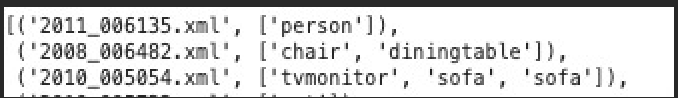

Solution -> Using cropped parts of the images containing only one (main) object

In [251]:
image_dataset = pd.read_csv("image_dataset.csv") #thanks to our colleague Josep Maria Rocafort for the csv with the cropping data

In [252]:
train_images_filenames = image_dataset['file'].values

In [253]:
train_labels_folder = 'VOCdevkit/VOC2012/JPEGImages/'
isExist = os.path.exists("altered")
if isExist == False:
    for idx, row in image_dataset.iterrows():
        image = cv2.imread(train_labels_folder+row["file"]+".jpg") #read image
        image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY) #convert to grayscale
        image = image[row["ymin"]:row["ymax"],row["xmin"]:row["xmax"]]
        cv2.imwrite("altered/"+row["file"]+".jpg", image)


In [254]:
images_train_paths = ['altered/' + s for s in train_images_filenames + '.jpg']
print("Made the paths!")

Made the paths!


In [255]:
train_images = load_images(files=images_train_paths, desc='Loading TRAIN images...') #it works, but there are a lot o warnings
train_labels = image_dataset[['class']].values


Loading TRAIN images...: 100%|██████████| 20515/20515 [00:04<00:00, 4685.72it/s]

read: 20515 images


Total number of training samples: 20515


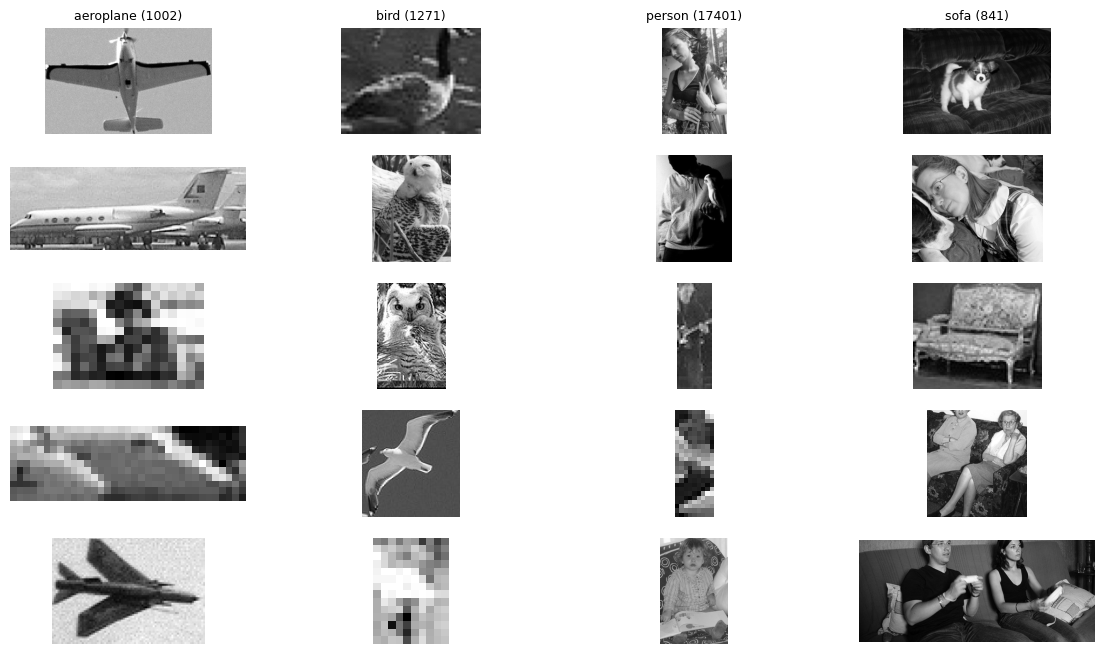

In [224]:
train = Dataset(images_train_paths, train_labels)
train.visualize()

We can already see an imbalance in the data. While the aeroplane, bird and sofa images counts are quite similar, the person images is clearly dominant.

In [225]:
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, test_size=0.33, random_state=15)

In [226]:
train_images = X_train
train_labels = y_train
test_images = X_test
test_labels = y_test

### SIFT + AKAZE Hyperparameter tunning with GridSearchCV
We perform a hyperparameters search browsing throught SIFT and AKAZE local features detectors and the most relevant parameters: number of features, codebook size (bins of the histogram), knn's number of neighbors and several distance metrics (euclidean, manhattan).

<font color='red'>WARNING: </font>There is no need to execute the following cells as the results are already saved in a .csv file (the content is shown later).

In [ ]:
params = {
    'detector': ['akaze','sift'],
    'n_features': [200,300],
    'codebook_size': [200,500],
    'n_neighbors': [3,5,9,13],
    'metric': ["euclidean", 'manhattan']
}

evaluation_metrics = ['accuracy', 'f1_weighted']
results_folder = 'results'
filename = 'hyper_params_knn.csv'

results = []
for detector in params['detector']:
    for n_features in params['n_features']:

        train_descriptors, filtered_train_labels = compute_descriptors(
            images=train_images,
            labels=train_labels,
            detector=detector,
            n_features=n_features,
            desc='Computing descriptors for TRAIN images...'
        )
        for codebook_size in params['codebook_size']:

            cbook = generate_codebook(train_descriptors, codebook_size=codebook_size)
            train_visual_words = compute_visual_words(
                descriptors=train_descriptors,
                codebook=cbook,
                codebook_size=codebook_size,
                desc="Computing visual words vocabulary with TRAIN descriptors..."
            )

            clf = KNeighborsClassifier(n_jobs=-1)
            clf_grid = GridSearchCV(
                estimator=clf,
                param_grid={k: params[k] for k in ('n_neighbors', 'metric') if k in params},
                cv=8,
                scoring=evaluation_metrics,
                refit="accuracy",
                return_train_score=True)
            clf_grid.fit(train_visual_words, filtered_train_labels)

            idx_best_accuracy = np.argmin(clf_grid.cv_results_['rank_test_accuracy'])

            # Params
            n_neighbors = clf_grid.best_params_['n_neighbors']
            distance = clf_grid.best_params_['metric']
            step_size = "-"

            results_data = [detector, n_features, step_size, codebook_size, n_neighbors, distance]

            # Scores
            for eval_metric in evaluation_metrics:
                train_score = clf_grid.cv_results_['mean_train_' + eval_metric][idx_best_accuracy]
                val_score = clf_grid.cv_results_['mean_test_' + eval_metric][idx_best_accuracy]
                std_train_score = clf_grid.cv_results_['std_train_' + eval_metric][idx_best_accuracy]
                std_val_score = clf_grid.cv_results_['std_test_' + eval_metric][idx_best_accuracy]
                results_data.extend([train_score, val_score, std_train_score, std_val_score])

            results.append(results_data)
            print(f"Appended GridSearchCV results for {detector} with {n_features} features and {codebook_size} codebook size.")
            
            
columns = ['detector', 'n_features','step_size', 'codebook_size', 'n_neighbors', 'distance'] \

for eval_metric in evaluation_metrics:
    columns.extend([f'train_{eval_metric}', f'val_{eval_metric}', f'std_train_{eval_metric}', f'std_val_{eval_metric}'])
    
df = pd.DataFrame(results, columns=columns)
os.makedirs(results_folder, exist_ok=True)
df.to_csv(os.path.join(results_folder, filename))
print(f"Saved results to {os.path.join(results_folder, filename)}")

Appended GridSearchCV results for akaze with 200 features and 200 codebook size.


Appended GridSearchCV results for akaze with 200 features and 500 codebook size.


Appended GridSearchCV results for akaze with 300 features and 200 codebook size.


Appended GridSearchCV results for akaze with 300 features and 500 codebook size.


Appended GridSearchCV results for sift with 200 features and 200 codebook size.


Appended GridSearchCV results for sift with 200 features and 500 codebook size.


Appended GridSearchCV results for sift with 300 features and 200 codebook size.


### Bonus: Dense SIFT's  Grid Search

After analyzing and narrowing down the range of different parameters for a given detector (SIFT, AKAZE), we then perform a similar exhaustive search with a new keypoint detector: Dense-SIFT.

One key difference between SIFT and Dense-SIFT is that SIFT uses a sparse sampling of point in the image to detect keypoints, while Dense-SIFT uses a dense sampling of points covering the entire image. This emans that Dense-SIFT is able to detect more keypoints, but at the cost of increase computational complexity.

It introduces a new parameter, the step size. This refers to the distance between adjacent point in the dense sampling of an image and it can be used to control the density of the keypoints detection. A smaller step size will result in a denser sampling of the image, which will increase the number of keypoints detected but also increase the computational complexity and viceversa.




<font color='red'>WARNING: </font>There is no need to execute the following cells as the results are already saved in a .csv file (the content is shown later).

In [184]:
start = time.time()

params = {
    'detector': ['dense_sift'],
    'n_features': [1000],
    'codebook_size': [50,100,500,1000],
    'n_neighbors': [3,5,9,13,17,21],
    'metric': ["manhattan"], #in prior tests, we have also tried euclidean and four it to be inferior. 
                            #We chose to keep only one distance to reduce computational time.
    'step_size': [10, 20, 50, 100],
    'dr_methods': ["pca", "lda"]
}




evaluation_metrics = ['accuracy', 'f1_weighted']
results_folder = 'results'
filename = 'hyper_params_knn_dense_3.csv'

results = []

### Dense SIFT case
for detector in params['detector']:
    if detector == 'dense_sift':
        for n_features in params['n_features']:
            for step_sizes in params['step_size']:

                train_descriptors, filtered_train_labels = compute_descriptors(
                    images=train_images,
                    labels=train_labels,
                    detector=detector,
                    n_features=n_features,
                    step_size = step_sizes,
                    desc='Computing descriptors for TRAIN images...'
                )
                for codebook_size in params['codebook_size']:

                    cbook = generate_codebook(train_descriptors, codebook_size=codebook_size)
                    train_visual_words = compute_visual_words(
                        descriptors=train_descriptors,
                        codebook=cbook,
                        codebook_size=codebook_size,
                        desc="Computing visual words vocabulary with TRAIN descriptors..."
                    )

                    clf = KNeighborsClassifier(n_jobs=-1)
                    clf_grid = GridSearchCV(
                        estimator=clf,
                        param_grid={k: params[k] for k in ('n_neighbors', 'metric') if k in params},
                        cv=8,
                        scoring=evaluation_metrics,
                        refit="accuracy",
                        return_train_score=True)
                    clf_grid.fit(train_visual_words, filtered_train_labels)

                    idx_best_accuracy = np.argmin(clf_grid.cv_results_['rank_test_accuracy'])

                    # Params
                    n_neighbors = clf_grid.best_params_['n_neighbors']
                    distance = clf_grid.best_params_['metric']
                    results_data = [detector, n_features, step_sizes, codebook_size, n_neighbors, distance]

                    # Scores
                    for eval_metric in evaluation_metrics:
                        train_score = clf_grid.cv_results_['mean_train_' + eval_metric][idx_best_accuracy]
                        val_score = clf_grid.cv_results_['mean_test_' + eval_metric][idx_best_accuracy]
                        std_train_score = clf_grid.cv_results_['std_train_' + eval_metric][idx_best_accuracy]
                        std_val_score = clf_grid.cv_results_['std_test_' + eval_metric][idx_best_accuracy]
                        results_data.extend([train_score, val_score, std_train_score, std_val_score])

                    results.append(results_data)
                    print(f"Appended GridSearchCV results for {detector} with {n_features} features, {step_sizes} step size and {codebook_size} codebook size.")

columns = ['detector', 'n_features','step_size', 'codebook_size', 'n_neighbors', 'distance'] \

for eval_metric in evaluation_metrics:
    columns.extend([f'train_{eval_metric}', f'val_{eval_metric}', f'std_train_{eval_metric}', f'std_val_{eval_metric}'])

df = pd.DataFrame(results, columns=columns)
os.makedirs(results_folder, exist_ok=True)
df.to_csv(os.path.join(results_folder, filename))
print(f"Saved results to {os.path.join(results_folder, filename)}")
end = time.time()
print(end - start)

Appended GridSearchCV results for dense_sift with 1000 features, 10 step size and 50 codebook size.


Appended GridSearchCV results for dense_sift with 1000 features, 10 step size and 100 codebook size.


Appended GridSearchCV results for dense_sift with 1000 features, 10 step size and 500 codebook size.


Appended GridSearchCV results for dense_sift with 1000 features, 10 step size and 1000 codebook size.


Appended GridSearchCV results for dense_sift with 1000 features, 20 step size and 50 codebook size.


Appended GridSearchCV results for dense_sift with 1000 features, 20 step size and 100 codebook size.


Appended GridSearchCV results for dense_sift with 1000 features, 20 step size and 500 codebook size.


Appended GridSearchCV results for dense_sift with 1000 features, 20 step size and 1000 codebook size.


Appended GridSearchCV results for dense_sift with 1000 features, 50 step size and 50 codebook size.


Appended GridSearchCV results for dense_sift with 1000 features, 50 step size and 100 codebook size.


Appended GridSearchCV results for dense_sift with 1000 features, 50 step size and 500 codebook size.


Appended GridSearchCV results for dense_sift with 1000 features, 50 step size and 1000 codebook size.


Appended GridSearchCV results for dense_sift with 1000 features, 100 step size and 50 codebook size.


Appended GridSearchCV results for dense_sift with 1000 features, 100 step size and 100 codebook size.


Appended GridSearchCV results for dense_sift with 1000 features, 100 step size and 500 codebook size.


Appended GridSearchCV results for dense_sift with 1000 features, 100 step size and 1000 codebook size.
Saved results to results/hyper_params_knn_dense_3.csv
12886.127866744995


The following table shows the results of the Dense-SIFT's hyperparameter search.

In [10]:
df_dense = pd.read_csv('results/hyper_params_knn_dense_3.csv', index_col=0)
df= pd.read_csv('results/hyper_params_knn.csv', index_col=0)
df_dense

detector  n_features  step_size  codebook_size  n_neighbors   distance  \
0   dense_sift        1000         10             50            3  manhattan   
1   dense_sift        1000         10            100            3  manhattan   
2   dense_sift        1000         10            500           21  manhattan   
3   dense_sift        1000         10           1000           21  manhattan   
4   dense_sift        1000         20             50            9  manhattan   
5   dense_sift        1000         20            100           13  manhattan   
6   dense_sift        1000         20            500           21  manhattan   
7   dense_sift        1000         20           1000           21  manhattan   
8   dense_sift        1000         50             50           17  manhattan   
9   dense_sift        1000         50            100           21  manhattan   
10  dense_sift        1000         50            500           21  manhattan   
11  dense_sift        1000         50           1000           21  manhattan   
12  dense_sift        1000        100             50           21  manhattan   
13  dense_sift        1000        100            100           21  manhattan   
14  dense_sift        1000        100            500           13  manhattan   
15  dense_sift        1000        100           1000            9  manhattan   

    train_accuracy  val_accuracy  std_train_accuracy  std_val_accuracy  \
0         0.925583      0.887887            0.001066          0.004590   
1         0.924128      0.885559            0.000699          0.003738   
2         0.870997      0.867661            0.001281          0.002957   
3         0.866798      0.861550            0.001178          0.003522   
4         0.888053      0.878138            0.000691          0.004671   
5         0.883074      0.875664            0.001022          0.003272   
6         0.863608      0.858348            0.001977          0.002246   
7         0.872078      0.868679            0.000754          0.003180   
8         0.877618      0.874136            0.000706          0.002909   
9         0.876766      0.873700            0.000684          0.002631   
10        0.874625      0.871953            0.000755          0.002668   
11        0.874302      0.872390            0.000425          0.001873   
12        0.872515      0.870935            0.000572          0.002557   
13        0.870748      0.868170            0.001569          0.004063   
14        0.874562      0.869552            0.001669          0.004461   
15        0.881463      0.875009            0.001020          0.004655   

    train_f1_weighted  val_f1_weighted  std_train_f1_weighted  \
0            0.917317         0.871995               0.001382   
1            0.915971         0.870794               0.000792   
2            0.836693         0.832369               0.001309   
3            0.828855         0.822643               0.001305   
4            0.861587         0.847771               0.001244   
5            0.854471         0.844881               0.001498   
6            0.831219         0.826042               0.001973   
7            0.834969         0.830823               0.001245   
8            0.843029         0.837836               0.001123   
9            0.840432         0.836679               0.001419   
10           0.829240         0.824914               0.001727   
11           0.828333         0.825407               0.000750   
12           0.832428         0.830556               0.000998   
13           0.827371         0.824674               0.002155   
14           0.842439         0.836109               0.002045   
15           0.854276         0.844974               0.001690   

    std_val_f1_weighted  
0              0.004976  
1              0.003625  
2              0.004155  
3              0.004321  
4              0.005238  
5              0.003594  
6              0.003551  
7              0.004250  
8              0.003564  
9              0.002

From the experiments, we can see that the best results, judging by the validation accuracy, using Dense-SIFT are obtained with the following params:
- n_features: 1000
- step_size: 10
- codebook_size: 50
- n_neighbors: 3
- distance: manhattan

A training accuracy of 0.925

A validation accuracy of 0.887

Note that in our case, the number of features is not a relevant parameter, but the step size had an strong influence in the performance. 

Here we just append both hyperparameter searches.

In [11]:
df_results = pd.concat([df, df_dense], ignore_index=True)
df_results

detector  n_features step_size  codebook_size  n_neighbors   distance  \
0        akaze         200         -            200           13  euclidean   
1        akaze         200         -            500           13  manhattan   
2        akaze         300         -            200           13  euclidean   
3        akaze         300         -            500           13  euclidean   
4         sift         200         -            200           13  euclidean   
5         sift         200         -            500           13  euclidean   
6         sift         300         -            200           13  euclidean   
7         sift         300         -            500           13  euclidean   
8   dense_sift        1000        10             50            3  manhattan   
9   dense_sift        1000        10            100            3  manhattan   
10  dense_sift        1000        10            500           21  manhattan   
11  dense_sift        1000        10           1000           21  manhattan   
12  dense_sift        1000        20             50            9  manhattan   
13  dense_sift        1000        20            100           13  manhattan   
14  dense_sift        1000        20            500           21  manhattan   
15  dense_sift        1000        20           1000           21  manhattan   
16  dense_sift        1000        50             50           17  manhattan   
17  dense_sift        1000        50            100           21  manhattan   
18  dense_sift        1000        50            500           21  manhattan   
19  dense_sift        1000        50           1000           21  manhattan   
20  dense_sift        1000       100             50           21  manhattan   
21  dense_sift        1000       100            100           21  manhattan   
22  dense_sift        1000       100            500           13  manhattan   
23  dense_sift        1000       100           1000            9  manhattan   

    train_accuracy  val_accuracy  std_train_accuracy  std_val_accuracy  \
0         0.841630      0.836062            0.000729          0.003274   
1         0.839804      0.832788            0.001293          0.002151   
2         0.841418      0.835516            0.000587          0.001776   
3         0.838612      0.832164            0.001100          0.002784   
4         0.858437      0.829164            0.002058          0.006478   
5         0.843696      0.801227            0.004366          0.006999   
6         0.858272      0.832083            0.001132          0.008544   
7         0.843143      0.798912            0.003004          0.014167   
8         0.925583      0.887887            0.001066          0.004590   
9         0.924128      0.885559            0.000699          0.003738   
10        0.870997      0.867661            0.001281          0.002957   
11        0.866798      0.861550            0.001178          0.003522   
12        0.888053      0.878138            0.000691          0.004671   
13        0.883074      0.875664            0.001022          0.003272   
14        0.863608      0.858348            0.001977          0.002246   
15        0.872078      0.868679            0.000754          0.003180   
16        0.877618      0.874136            0.000706          0.002909   
17        0.876766      0.873700            0.000684          0.002631   
18        0.874625      0.871953            0.000755          0.002668   
19        0.874302      0.872390            0.000425          0.001873   
20        0.872515      0.870935            0.000572          0.002557   
21        0.870748      0.868170            0.001569          0.004063   
22        0.874562      0.869552            0.001669          0.004461   
23        0.881463      0.875009            0.001020          0.004655   

    train_f1_weighted  val_f1_weighted  std_train_f1_weighted  \
0            0.777026         0.767415               0.001624   
1            0.775605         0.765460           

We can see that over all the experiments (SIFT+AKAZE and Dense-SIFT), Dense-SIFT outperforms all feature extractors. Also, there is a clear difference in performance between these detectors. Dense-SIFT outperforms AKAZE that outperforms SIFT.

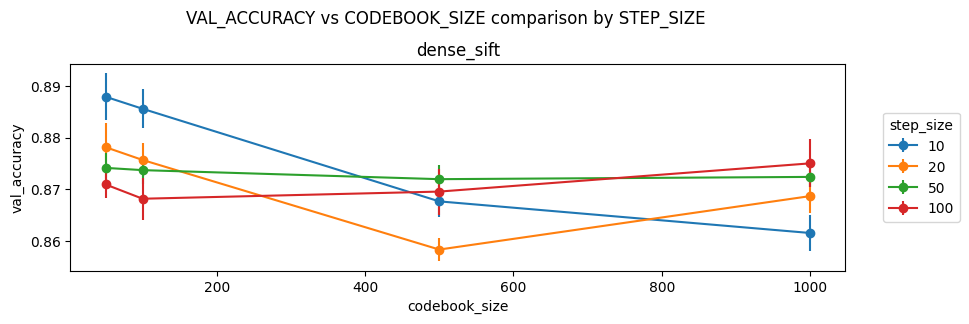

In [191]:
# ACCURACY
plot_params(
    df=df_dense[df_dense['n_features'] == 1000],
    detector='dense_sift',
    xvar='codebook_size',
    yvar='val_accuracy',
    zvar='step_size',
    figsize=(10, 3)
)

There are multiple parameters that play a role in the final accuracy. We wanted to ilustrate that with the plot above. One thing we can know for sure, is that the best accuracy was obatained with a small step_size. Our initial assumption was that a larger codebook size would also produce better results, but that was not the case. 

We think, however, that in a test with a higher number of classes, this may be the most important factor.

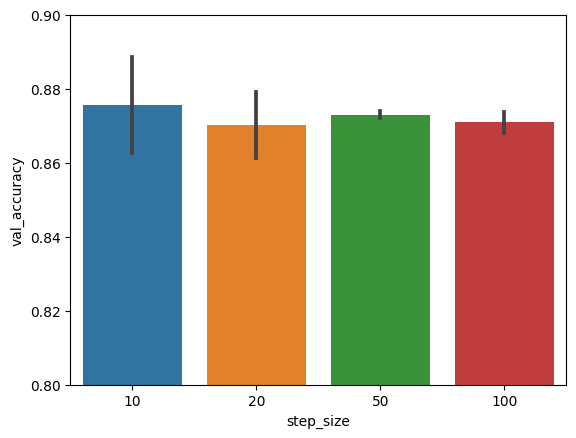

In [33]:
df = df_dense[df_dense['n_features'] < 2000]
sns.barplot(x = 'step_size',
            y = 'val_accuracy',
            data = df,
           ci = 'sd') #error is standard deviation
plt.ylim(0.8, 0.9) 
# Show the plot
plt.show()



Inspecting the plot above, we can consistently notice that smaller step size produce the best results. We note this behaviour to be pretty consistent when also taking the error bar in consideration, but the accuracy can drop up to 2% if the other parameters are not appropiate. The errorbar in the figure above represents standard deviation.

### Summary of best hyperparameters


We find the cases obtained with GridSearch where the validation score was the highest.

In [199]:
df_copy = df_results.copy()
df_copy = df_copy.sort_values("val_accuracy", ascending=False)
df_copy = df_copy.drop_duplicates(subset=["detector"], keep="first")
#df_copy.drop(columns=df.columns[0], axis=1, inplace=True)
df_copy = df_copy.drop(df_copy.iloc[:, 6:],axis = 1)
best_params = df_copy.values.tolist()

df_copy

detector  n_features step_size  codebook_size  n_neighbors   distance
8  dense_sift        1000        10             50            3  manhattan
0       akaze         200         -            200           13  euclidean
6        sift         300         -            200           13  euclidean

### Apply dimensionality reduction and compare the results

The objective of this section is to perform a search over PCA and LDA dimensionality reduction methods. We search the best number of dimensions to find the best results.

<font color='red'>WARNING: </font>There is no need to execute the following cells as the results are already saved in a .csv file (the content is shown later).

In [68]:
results = []
evaluation_metrics = ['accuracy', 'f1_weighted']
results_folder = 'results'
filename = 'hyper_params_dim_red_new.csv'
methods = ['pca', 'lda']
os.makedirs(results_folder, exist_ok=True)

for params in best_params:
    train_descriptors, train_labels = compute_descriptors(
                    images=train_images,
                    labels=train_labels,
                    detector=params[0],
                    n_features=params[1],
                    #step_size = 
                    desc='Computing descriptors for TRAIN images...'
                )
    test_descriptors, test_labels = compute_descriptors(
                    images=test_images,
                    labels=test_labels,
                    detector=params[0],
                    n_features=params[1],
                    #step_size = 
                    desc='Computing descriptors for TEST images...',
                    testing = True
                )
    cbook = generate_codebook(train_descriptors, params[3])
    train_visual_words = compute_visual_words(
        descriptors=train_descriptors,
        codebook=cbook,
        codebook_size=params[3],
        desc="Computing visual words vocabulary with TRAIN descriptors...",
        verbose=True)

    test_visual_words = compute_visual_words(
        descriptors=test_descriptors,
        codebook=cbook,
        codebook_size=params[3],
        desc="Computing visual words vocabulary with Test descriptors...",
        verbose=True)
    clf = KNeighborsClassifier(n_neighbors = params[4],metric = params[5] ,n_jobs=-1)
    clf.fit(train_visual_words, train_labels)
    print('\nRegular')
    reg_res = evaluate_vw_predictions(test_visual_words,test_labels, clf)

    for method in methods:
        if method == 'pca':
            reduced_dims = np.arange(5, 50, 5)
        elif method == 'lda':
            reduced_dims = np.arange(1, len(np.unique(test_labels))) 
        for red_dim in reduced_dims:
            red_clf = KNeighborsClassifier(n_neighbors = params[4],metric = params[5] ,n_jobs=-1)
            dim_red = get_dimension_reduction(dim_red_name=method, n_components=red_dim)
            red_visual_words = dim_red.fit_transform(train_visual_words, train_labels)
            if method == 'pca':
                plt.plot(np.cumsum(dim_red.explained_variance_ratio_), 'ro-')
                plt.grid()
                plt.title("PCA with " + str(red_dim) + " components")
                plt.savefig(results_folder +'/' + str(red_dim) + ".png" )
                plt.close()
            red_clf.fit(red_visual_words, train_labels)
            red_visual_words_test = dim_red.transform(test_visual_words)
            print('\nDim red')
            res = evaluate_vw_predictions(red_visual_words_test,test_labels, red_clf)

            results_data = [params[0], params[1], params[2], params[3], params[4], params[5], method, red_dim, reg_res ,res]

            results.append(results_data)
            print(f" Using {params[0]} with {params[1]} features, {params[2]} step size and {params[3]} codebook size. Appended GridSearch results for {method} with {red_dim} reduced dimension.")

            
columns = ['detector', 'n_features','step_size', 'codebook_size', 'n_neighbors', 'distance', 'method', 'reduced_dimensions', 'regular_accuracy', 'dim_red_accuracy']
df_dr = pd.DataFrame(results, columns=columns)
os.makedirs(results_folder, exist_ok=True)
df_dr.to_csv(os.path.join(results_folder, filename))
print(f"Saved results to {os.path.join(results_folder, filename)}")

Computing visual words vocabulary with TRAIN descriptors...: 100%|█| 13745/13745



Generated 13745 histograms with a k=50 vocabulary.

Number of images where keypoints were not detected: 0


Computing visual words vocabulary with Test descriptors...: 100%|█| 6770/6770 [0



Generated 6770 histograms with a k=50 vocabulary.

Number of images where keypoints were not detected: 0

Regular

The trained model generates results with 88.38995568685377 accuracy.

Dim red

The trained model generates results with 87.53323485967503 accuracy.
 Using dense_sift with 500 features, 50 step size and 50 codebook size. Appended GridSearch results for pca with 5 reduced dimension.

Dim red

The trained model generates results with 88.07976366322009 accuracy.
 Using dense_sift with 500 features, 50 step size and 50 codebook size. Appended GridSearch results for pca with 10 reduced dimension.

Dim red

The trained model generates results with 87.99113737075332 accuracy.
 Using dense_sift with 500 features, 50 step size and 50 codebook size. Appended GridSearch results for pca with 15 reduced dimension.

Dim red

The trained model generates results with 87.96159527326441 accuracy.
 Using dense_sift with 500 features, 50 step size and 50 codebook size. Appended GridSearch res

Computing visual words vocabulary with TRAIN descriptors...: 100%|█| 8673/8673 [



Generated 8673 histograms with a k=200 vocabulary.

Number of images where keypoints were not detected: 0


Computing visual words vocabulary with Test descriptors...: 100%|█| 6770/6770 [0



Generated 6770 histograms with a k=200 vocabulary.

Number of images where keypoints were not detected: 2615

Regular

The trained model generates results with 85.02215657311669 accuracy.

Dim red

The trained model generates results with 85.05169867060562 accuracy.
 Using akaze with 200 features, - step size and 200 codebook size. Appended GridSearch results for pca with 5 reduced dimension.

Dim red

The trained model generates results with 85.05169867060562 accuracy.
 Using akaze with 200 features, - step size and 200 codebook size. Appended GridSearch results for pca with 10 reduced dimension.

Dim red

The trained model generates results with 85.02215657311669 accuracy.
 Using akaze with 200 features, - step size and 200 codebook size. Appended GridSearch results for pca with 15 reduced dimension.

Dim red

The trained model generates results with 85.03692762186115 accuracy.
 Using akaze with 200 features, - step size and 200 codebook size. Appended GridSearch results for pca wit

Computing visual words vocabulary with TRAIN descriptors...: 100%|█| 8392/8392 [



Generated 8392 histograms with a k=200 vocabulary.

Number of images where keypoints were not detected: 0


Computing visual words vocabulary with Test descriptors...: 100%|█| 6770/6770 [0



Generated 6770 histograms with a k=200 vocabulary.

Number of images where keypoints were not detected: 212

Regular

The trained model generates results with 85.12555391432792 accuracy.

Dim red

The trained model generates results with 85.11078286558346 accuracy.
 Using sift with 300 features, - step size and 200 codebook size. Appended GridSearch results for pca with 5 reduced dimension.

Dim red

The trained model generates results with 85.12555391432792 accuracy.
 Using sift with 300 features, - step size and 200 codebook size. Appended GridSearch results for pca with 10 reduced dimension.

Dim red

The trained model generates results with 85.096011816839 accuracy.
 Using sift with 300 features, - step size and 200 codebook size. Appended GridSearch results for pca with 15 reduced dimension.

Dim red

The trained model generates results with 85.12555391432792 accuracy.
 Using sift with 300 features, - step size and 200 codebook size. Appended GridSearch results for pca with 20 re

The following file summarizes the search over the methods (LDA and PCA). Note that the regular accuracy refers to the accuracy without performing dimensionality reduction and dim_red_accuracy refers to applying the dimensionality reduction method.

We expect an increase of predictive performance when using these methods.

In [70]:
df_results = pd.read_csv('results/hyper_params_dim_red_new.csv', index_col=0)
df_results

detector  n_features step_size  codebook_size  n_neighbors   distance  \
0   dense_sift         500        50             50           13  manhattan   
1   dense_sift         500        50             50           13  manhattan   
2   dense_sift         500        50             50           13  manhattan   
3   dense_sift         500        50             50           13  manhattan   
4   dense_sift         500        50             50           13  manhattan   
5   dense_sift         500        50             50           13  manhattan   
6   dense_sift         500        50             50           13  manhattan   
7   dense_sift         500        50             50           13  manhattan   
8   dense_sift         500        50             50           13  manhattan   
9   dense_sift         500        50             50           13  manhattan   
10  dense_sift         500        50             50           13  manhattan   
11  dense_sift         500        50             50           13  manhattan   
12       akaze         200         -            200           13  euclidean   
13       akaze         200         -            200           13  euclidean   
14       akaze         200         -            200           13  euclidean   
15       akaze         200         -            200           13  euclidean   
16       akaze         200         -            200           13  euclidean   
17       akaze         200         -            200           13  euclidean   
18       akaze         200         -            200           13  euclidean   
19       akaze         200         -            200           13  euclidean   
20       akaze         200         -            200           13  euclidean   
21       akaze         200         -            200           13  euclidean   
22       akaze         200         -            200           13  euclidean   
23       akaze         200         -            200           13  euclidean   
24        sift         300         -            200           13  euclidean   
25        sift         300         -            200           13  euclidean   
26        sift         300         -            200           13  euclidean   
27        sift         300         -            200           13  euclidean   
28        sift         300         -            200           13  euclidean   
29        sift         300         -            200           13  euclidean   
30        sift         300         -            200           13  euclidean   
31        sift         300         -            200           13  euclidean   
32        sift         300         -            200           13  euclidean   
33        sift         300         -            200           13  euclidean   
34        sift         300         -            200           13  euclidean   
35        sift         300         -            200           13  euclidean   

   method  reduced_dimensions  regular_accuracy  dim_red_accuracy  
0     pca                   5          0.883900          0.875332  
1     pca                  10          0.883900          0.880798  
2     pca                  15          0.883900          0.879911  
3     pca                  20          0.883900          0.879616  
4     pca                  25          0.883900          0.882570  
5     pca                  30          0.883900          0.879321  
6     pca                  35          0.883900          0.882570  
7     pca                  40          0.883900          0.882866  
8     pca                  45          0.883900          0.881832  
9     lda                   1          0.883900          0.866027  
10    lda                   2          0.883900          0.868981  
11    lda                   3          0.883900          0.868242  
12    pca                   5          0.850222          0.850517  
13    pca                  10          0.850222          0.850517  
14    pca                  15          0.850222          0.850

From the experiments, we can see that the best results using dimensionality reduction are obtained with the following params:

With LDA:
- reduced_dimensions: 2

A validation regular accuracy of 0.883 and dim_red_accuracy of 0.868

With PCA:
- reduced_dimensions: 40

A validation regular accuracy of 0.883 and dim_red_accuracy of 0.882

Next, we perform a study on the number of components of PCA based on the ammount of variance explained by adding more components.

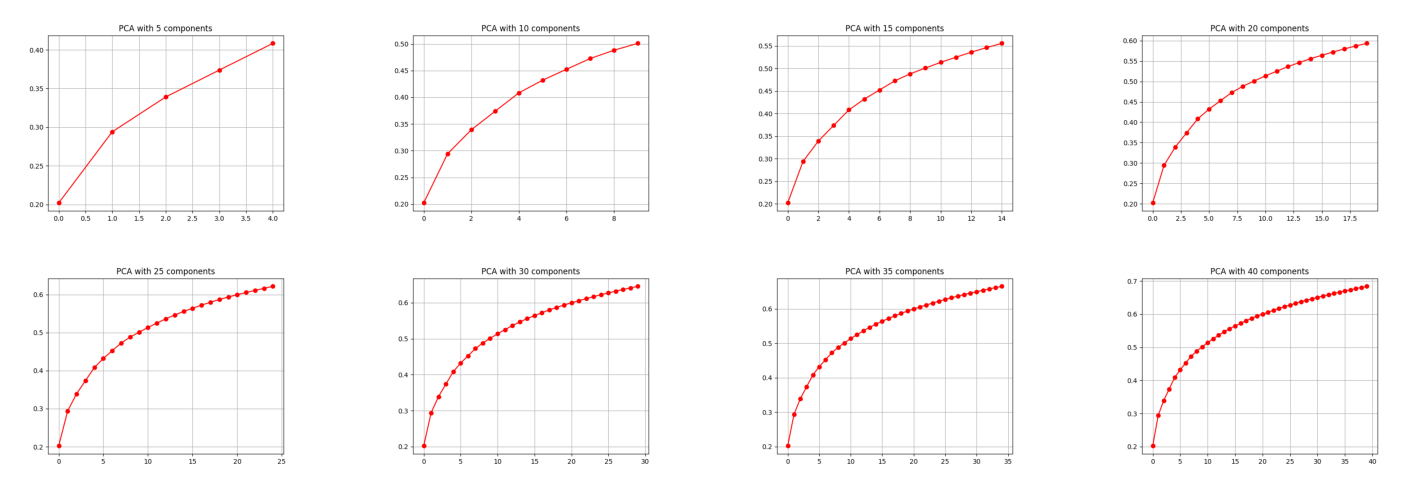

In [240]:
# Fit PCA to the training data
pca_an = PCA()
X_pca = pca_an.fit_transform(train_visual_words, train_labels)

# PLOTTING THE CUMULATIVE SUM OF THE EXPLAINED VARIANCE RATIO
fig = plt.figure(figsize=(15, 5))
columns = 4
rows = 2
counter_im = 5 #based on the naming of the images, this may need to be changed

for i in range(1, columns*rows +1):
    try:
        img = mpimg.imread(results_folder +'/'+ str(counter_im)+'.png') # getting the images with names 5.png, 25.png, 45.png...
        fig.add_subplot(rows, columns, i)
        plt.grid(False)
        plt.axis('off')
        plt.tight_layout()
        plt.imshow(img)
        counter_im = counter_im + 5
    except:
        pass

plt.show()

The main difference between PCA and LDA is the goal of the transformation.

PCA is used to reduce the number of dimensions in the dataset while retaining as much information as possible. It achieves it by creating new linearly uncorrelated variables (the principal components) that are ranked by how much they explain the variance in the data. However, it does not now anything about classes.

On the other hand, LDA is used to project data onto a lower-dimensional space that maximizes class separability. In other words, it is used to find the directions in which the data varies the most while maximizing the separation between differen classes.

That is also why, PCA performs better in case where number of samples per class is less. Whereas LDA works better with large datasets having multiple cases, where class separability is an important factor while reducing dimensionality.

The plots show the data variation based on the number of components. As we can see in those cases, there aren't many independent or redundant features. The variation of data highly depends on the first components, but it still steadly increases to the end.

This could be because the vocabulary is diverse, and, therefore, the visual words define different features that are not highly correlated.

That's why, by applying dimensionality reduction with PCA (or LDA, but that performed even worse) we achieve only a slight decrease in accuracy. The usefull part, however is the reduced coputational cost that comes with it, which we consider to be the real benefit.

### Final Best Accuracy on test data  - 0.883



## Visualization

In [227]:
# first we need to binarize the labels
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
y_train = lb.fit_transform(train_labels)
y_test = lb.fit_transform(test_labels)
n_classes = y_train.shape[1]
print(y_train)

[[0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 ...
 [0 1 0 0]
 [0 1 0 0]
 [0 0 1 0]]


In [228]:
for i in ['aeroplane', 'bird', 'person', 'sofa']:
    x = np.count_nonzero(test_labels == i)
    print("Number of images of class", i)
    print(x)

Number of images of class aeroplane
322
Number of images of class bird
430
Number of images of class person
5728
Number of images of class sofa
290


In [229]:
params = best_params[0] #dense sift
params

['dense_sift', 1000, 10, 50, 3, 'manhattan']

In [230]:
train_descriptors, train_labels = compute_descriptors(
                    images=train_images,
                    labels=train_labels,
                    detector=params[0],
                    n_features=params[1],
                    #step_size = 
                    desc='Computing descriptors for TRAIN images...'
                )
test_descriptors, test_labels = compute_descriptors(
                images=test_images,
                labels=test_labels,
                detector=params[0],
                n_features=params[1],
                #step_size = 
                desc='Computing descriptors for TEST images...',
                testing = True
            )
cbook = generate_codebook(train_descriptors, params[3])
train_visual_words = compute_visual_words(
    descriptors=train_descriptors,
    codebook=cbook,
    codebook_size=params[3],
    desc="Computing visual words vocabulary with TRAIN descriptors...",
    verbose=True)

test_visual_words = compute_visual_words(
    descriptors=test_descriptors,
    codebook=cbook,
    codebook_size=params[3],
    desc="Computing visual words vocabulary with Test descriptors...",
    verbose=True)

Computing visual words vocabulary with TRAIN descriptors...: 100%|█| 13745/13745



Generated 13745 histograms with a k=50 vocabulary.

Number of images where keypoints were not detected: 0


Computing visual words vocabulary with Test descriptors...: 100%|█| 6770/6770 [0



Generated 6770 histograms with a k=50 vocabulary.

Number of images where keypoints were not detected: 0


In [231]:
# classifier
clf = OneVsRestClassifier(svm.SVC())
clf.fit(train_visual_words, y_train)
y_score = clf.decision_function(test_visual_words)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

In [232]:
# Then interpolate all ROC curves 
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

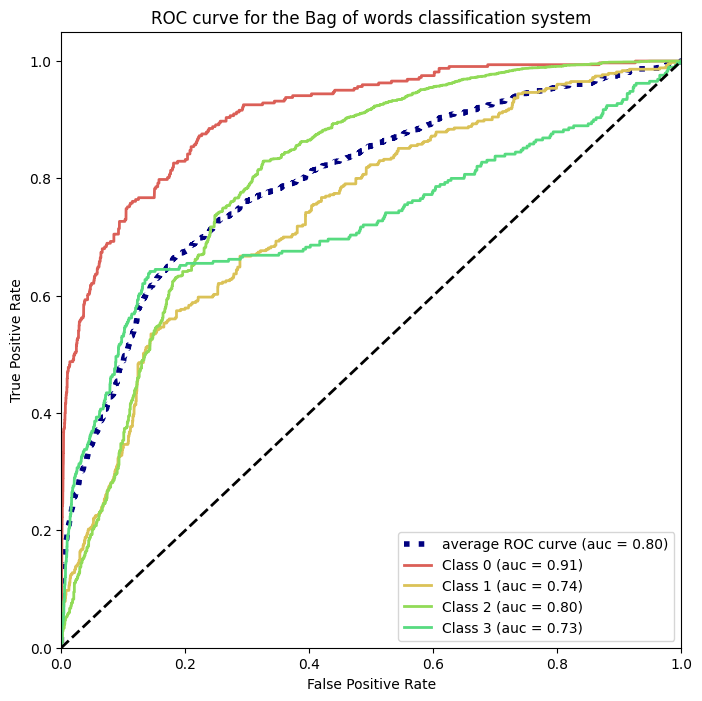

In [233]:
# Plot all ROC curves
plt.figure(figsize=(8,8))
lw = 2
plt.plot(fpr["macro"], tpr["macro"],
         label='average ROC curve (auc = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

palette = sns.color_palette("hls", 8)
colors = cycle(palette)
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='Class {0} (auc = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for the Bag of words classification system')
plt.legend(loc="lower right")
plt.show()

The classes are : ['aeroplane', 'bird', 'person', 'sofa']

Judging by the ROC curve, best performance can be seen in 'aeroplane' class and the worst can be seen in the 'sofa' class. This was done using the OneVsRestClassifier with a SVM classifier from sklearn. The reason for this is because K-NN was not suitable for this kind of classification.

In [234]:
clf = KNeighborsClassifier(n_neighbors = params[4],metric = params[5] ,n_jobs=-1)
clf.fit(train_visual_words, train_labels)
test_prediction = clf.predict(test_visual_words)

In [236]:
cm = confusion_matrix(test_labels, test_prediction, labels=['aeroplane', 'bird', 'person', 'sofa'])

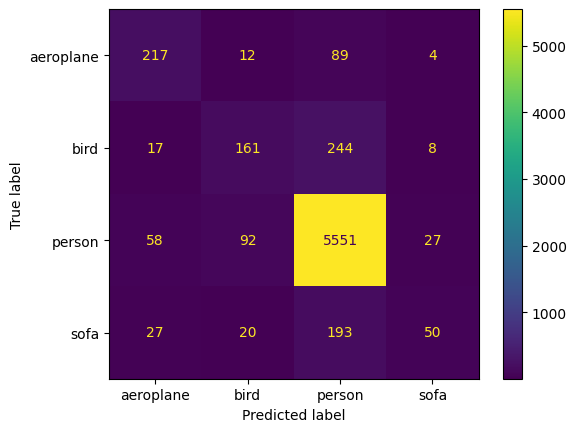

In [237]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()

The imbalance in the dataset is reflected in the confusion matrix. One other issue that we have noticed is that ther are classes within classes in the same images. A clear example are people that stay on sofas. Even with the cropping done, this is still an issue.

# Conclusion

 - Dense SIFT performed best in our tests with SIFT vs AKAZE vs Dense SIFT
 - The dimensionality reduction techniques helped in reducing the computational cost, but did not improve the performance
 - Some parameters are more important than others -> number of features, the number of neighbours in K-NN and the metric did not change the accuracy that much
 - We wanted to improve the accuracy even more, with a wider range in the parameter search, but the tests took too long to compute (The final Dense SIFT search, by itself, took ~3 hours)
 - We have increased and tested the robustness of our system in multiple ways: cross validating the results in the pipeline, splitting the data in training and testing sets and using dimensionality reduction.
 - As accuracy by itself tells only a part of the performance of the system, we have included the ROC curve and the confusion matrix also.
 
